In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
import numpy as np
import pickle

from scripts.agents import QLearningAgent, SARSAAgent
from scripts.training import Trainer, trainingInspector, test_agent, plot_test_results
from scripts.tilecoding import QTable

### Top 3 hyperparameters for Q-Learning and SARSA

In [2]:
# Top 3 hyperparameters for Q-Learning and SARSA
qlearning_hyperparameter_list = [
    
    # Best performing hyperparameters
    {
        "num_episodes": 10000,
        "max_return": -100,
        "num_tiles_per_feature": 20,
        "num_tilings": 1,
        "learning_rate": 0.1,
        "tau_start": 100000,
        "tau_end": 0.1,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.3
    },
    # Second best performing hyperparameters
    {
        "num_episodes": 10000,
        "max_return": -100,
        "num_tiles_per_feature": 10,
        "num_tilings": 1,
        "learning_rate": 0.1,
        "tau_start": 100000,
        "tau_end": 0.1,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.5
    },
    # Third best performing hyperparameters
    {
        "num_episodes": 10000,
        "max_return": -100,
        "num_tiles_per_feature": 20,
        "num_tilings": 4,
        "learning_rate": 0.1,
        "tau_start": 100000,
        "tau_end": 0.1,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.3
    }
    
]

sarsa_hyperparameter_list = [
    
    # Best performing hyperparameters
    {
        "num_episodes": 10000,
        "max_return": -100,
        "num_tiles_per_feature": 20,
        "num_tilings": 1,
        "learning_rate": 0.1,
        "eps_start": 1,
        "eps_end": 0.01,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.1
    },
    # Second best performing hyperparameters
    {
        "num_episodes": 10000,
        "max_return": -100,
        "num_tiles_per_feature": 20,
        "num_tilings": 1,
        "learning_rate": 0.1,
        "eps_start": 1,
        "eps_end": 0.01,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.3
    },
    # Third best performing hyperparameters
    {
        "num_episodes": 10000,
        "max_return": -100,
        "num_tiles_per_feature": 20,
        "num_tilings": 4,
        "learning_rate": 0.1,
        "eps_start": 1,
        "eps_end": 0.01,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.5
    }
]


## Running experiments - No Reward shaping

In [3]:
def episode_trigger(x):
    if x % 1000 == 0:
        return True
    return False

In [4]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder="backups/mountaincar-qlearning-visualizations",
    name_prefix="eval",
    episode_trigger=episode_trigger
)

qlearning_agent = QLearningAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    seed=0
)

sarsa_agent = SARSAAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    seed=0
)

trainer = Trainer()
qlearning_results = test_agent(env, qlearning_agent, trainer, qlearning_hyperparameter_list, num_experiments=5)
sarsa_results = test_agent(env, sarsa_agent, trainer, sarsa_hyperparameter_list, num_experiments=5)

env.close()

/home/lalit/my_venvs/rl_env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/lalit/acads/DA6400/Assignment1/DA6400_RL_PA1/backups/mountaincar-qlearning-visualizations folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:07<00:00, 40.40it/s, Mean Score=-148]


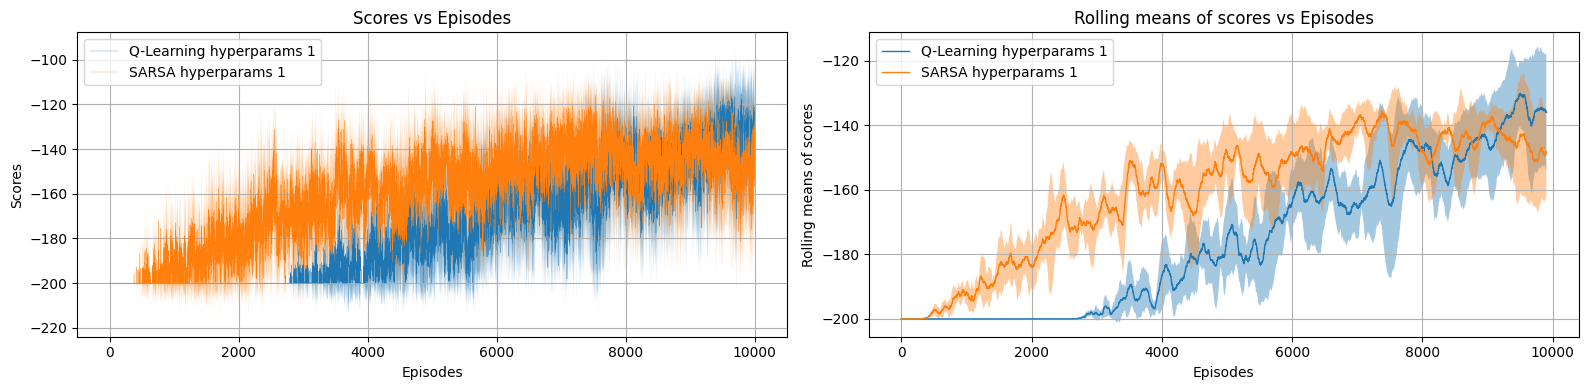

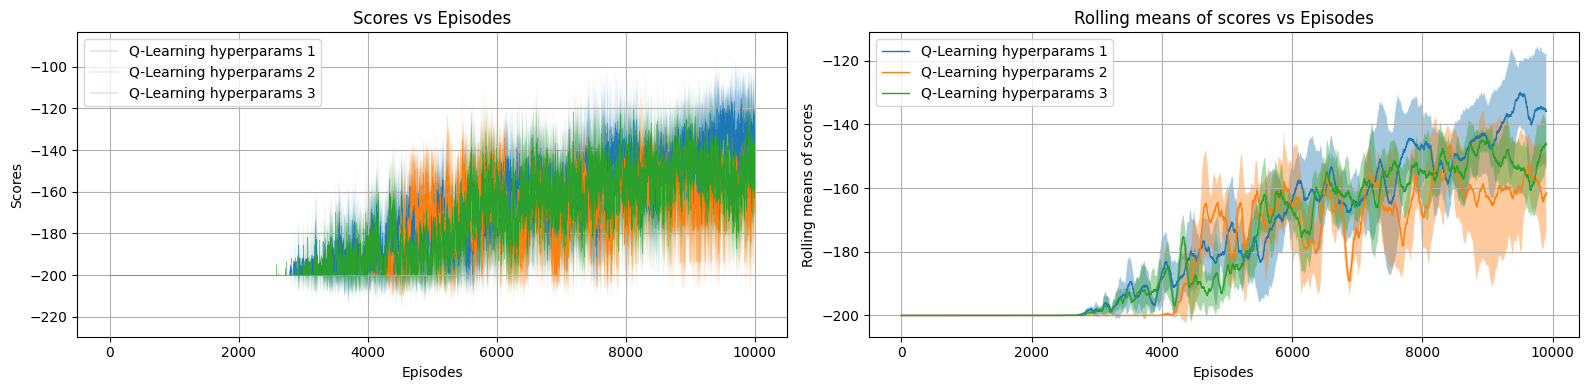

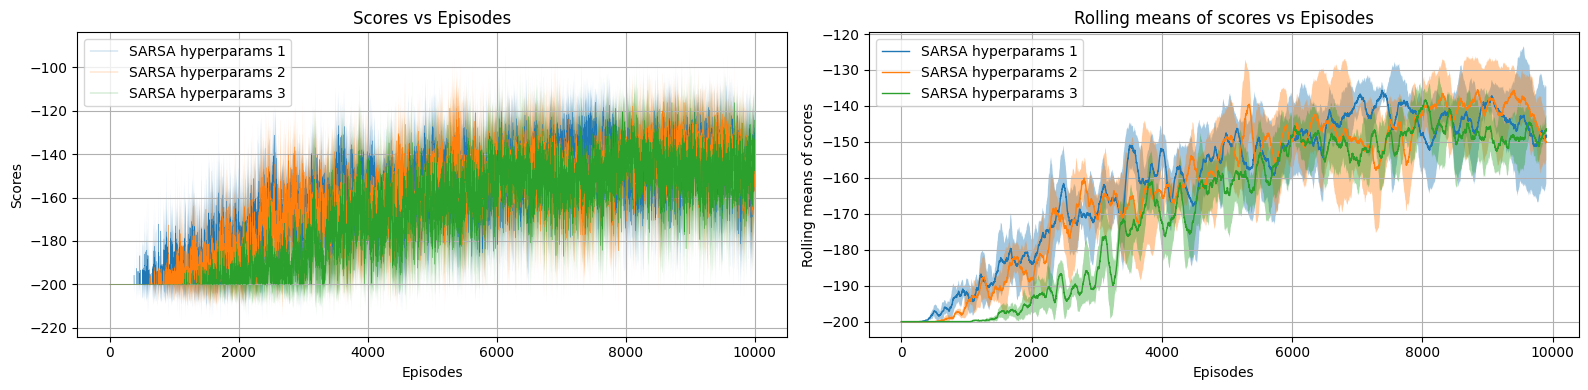

In [5]:
combined_results = qlearning_results + sarsa_results

with open("backups/mountaincar-plots/mountaincar_qlearning_results.pickle", 'wb') as handle:
    pickle.dump(qlearning_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("backups/mountaincar-plots/mountaincar_sarsa_results.pickle", 'wb') as handle:
    pickle.dump(sarsa_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot_test_results(combined_results, [0, 3])
plt.savefig("backups/mountaincar-plots/mountaincar_combined.png")
plot_test_results(qlearning_results, [0, 1, 2])
plt.savefig("backups/mountaincar-plots/mountaincar_qlearning.png")
plot_test_results(sarsa_results, [0, 1, 2])
plt.savefig("backups/mountaincar-plots/mountaincar_sarsa.png")

## Reward Shaping experiment

In [6]:
class RewShaper(gym.Wrapper):

    def __init__(self, env):
        super().__init__(env)
        self.prev_vel = 0

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        reward += 100*(action-1)*self.prev_vel
        self.prev_vel = observation[1]
        return observation, reward, terminated, truncated, info

class MountainCarTrainer(Trainer):
    def compute_score(self, reward):
        return -1

In [7]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder="backups/mountaincar-qlearning-visualizations",
    name_prefix="eval",
    episode_trigger=episode_trigger
)
env = RewShaper(env)

qlearning_agent = QLearningAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    seed=0
)

sarsa_agent = SARSAAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    seed=0
)

trainer = MountainCarTrainer()
qlearning_results = test_agent(env, qlearning_agent, trainer, qlearning_hyperparameter_list, num_experiments=5)
sarsa_results = test_agent(env, sarsa_agent, trainer, sarsa_hyperparameter_list, num_experiments=5)

env.close()

/home/lalit/my_venvs/rl_env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/lalit/acads/DA6400/Assignment1/DA6400_RL_PA1/backups/mountaincar-qlearning-visualizations folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.33it/s, Mean Score=-134]


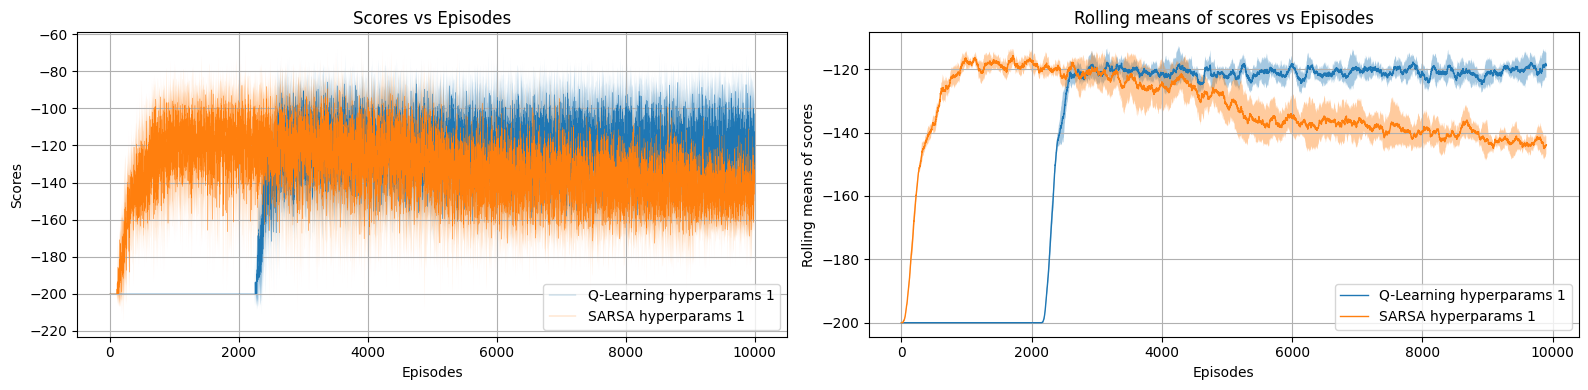

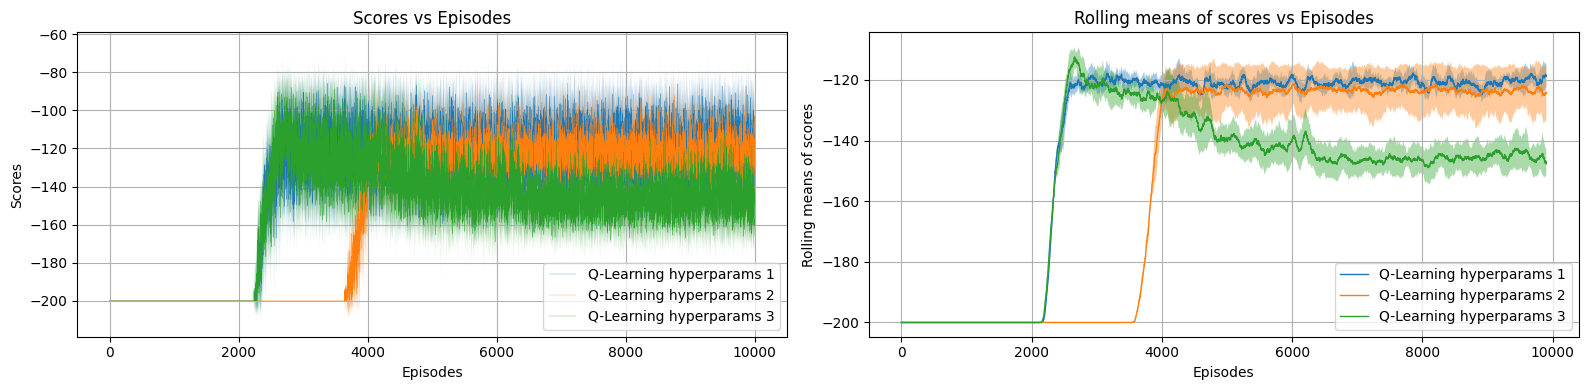

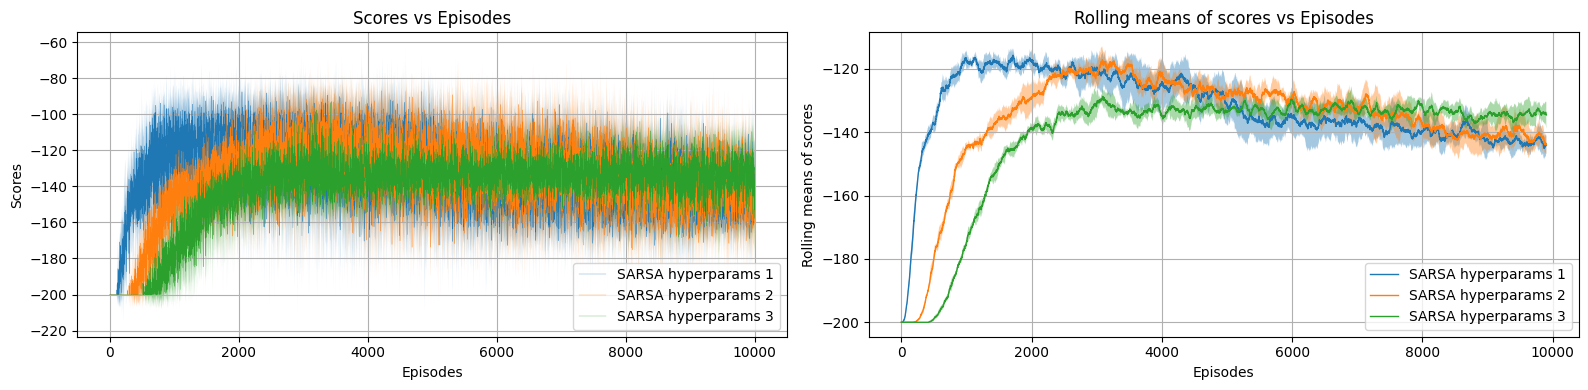

In [8]:
combined_results = qlearning_results + sarsa_results

with open("backups/mountaincar-plots/mountaincar_rewshape_qlearning_results.pickle", 'wb') as handle:
    pickle.dump(qlearning_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("backups/mountaincar-plots/mountaincar_rewshape_sarsa_results.pickle", 'wb') as handle:
    pickle.dump(sarsa_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot_test_results(combined_results, [0, 3])
plt.savefig("backups/mountaincar-plots/mountaincar_rewshape_combined.png")
plot_test_results(qlearning_results, [0, 1, 2])
plt.savefig("backups/mountaincar-plots/mountaincar_rewshape_qlearning.png")
plot_test_results(sarsa_results, [0, 1, 2])
plt.savefig("backups/mountaincar-plots/mountaincar_rewshape_sarsa.png")

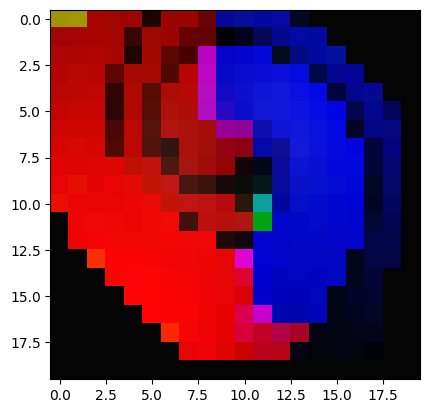

In [10]:
table = np.array(qlearning_agent.q_table.table)
im = np.reshape(table, (4,20,20,3))
im = (im[0]-np.min(im[0]))/(np.max(im[0])-np.min(im[0]))
plt.imshow(im)